In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

# O Imports

In [7]:
import os
# project path in GColab
#project_path = '/content/drive/My Drive/DataScience/supercoop/supercoapp-data-analysis/'
# project path in local ipython
project_path = '../../supercoapp-data-analysis'
os.chdir(project_path)

In [88]:
!ls


Dockerfile               data                     run_container_testing.sh
README.md                models                   run_ipython.sh
build_image.sh           notebooks                src
clean_up_order_table.rb  requirements.txt
clv-writeup.ipynb        run_container.sh


In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # matplotlib v3.2.2
import matplotlib.colors as mcolors
import seaborn as sns
sns.set()
%matplotlib inline

import src
import warnings
warnings.filterwarnings('ignore') # delete normal warnings to make code more clean

In [90]:
import sys
# lifetimes installation
!{sys.executable} -m pip install lifetimes
# lifetimes loading
from lifetimes.plotting import * # lifetimes visualization
from lifetimes.utils import * # transform

from lifetimes import BetaGeoFitter # BG/NBD model

from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix

In [91]:
!ls

Dockerfile               data                     run_container_testing.sh
README.md                models                   run_ipython.sh
build_image.sh           notebooks                src
clean_up_order_table.rb  requirements.txt
clv-writeup.ipynb        run_container.sh


# 1 Load Data

In [92]:
# set folder path
folder_path = '/Users/mariusprivat/Google Drive/DataScience/supercoop/supercoapp-data-analysis/data/processed'
# load data
df_orders, df_members, df_products = src.load_data(folder_path)

['20210417_scoop_orders.csv', '.DS_Store', '20210417_scoop_products.csv', '20210417_scoop_members.csv']
reminder: data from scoop company account (#46) is included


In [93]:
df_members.head()

,index,member_ID,order_ID,name,collected?,order_requests,deposits,delivery_date,order_request_value
0,0,1,1,XXX,True,"{'3': {'filled': '1.0', 'ordered': '1.0'}, '25...",NaN,2019-12-13,89.49
1,1,2,1,XXX,True,"{'39': {'filled': '1.0', 'ordered': '1.0'}, '6...",NaN,2019-12-13,16.22
2,2,3,1,XXX,True,"{'3': {'filled': '0.0', 'ordered': '2.0'}, '7'...",NaN,2019-12-13,20.28
3,3,4,1,XXX,True,"{'27': {'filled': '1.0', 'ordered': '1.0'}, '4...",NaN,2019-12-13,11.96
4,4,7,1,XXX,True,"{'27': {'filled': '1.0', 'ordered': '1.0'}, '1...",NaN,2019-12-13,17.32


# 2 Data Cleaning

In [94]:
df_members.delivery_date

0      2019-12-13
1      2019-12-13
2      2019-12-13
3      2019-12-13
4      2019-12-13
          ...    
3814   2021-03-19
3815   2021-03-19
3816   2021-03-19
3817   2021-03-19
3818   2021-03-19
Name: delivery_date, Length: 3819, dtype: datetime64[ns]

In [95]:
cols_of_interest = ['member_ID', 'delivery_date', 'order_request_value'] # select three variables that we are most caring
df = df_members[cols_of_interest]

print(df.head())
print('n_unique: ', df['member_ID'].nunique()) # how many unique customerID

   member_ID delivery_date  order_request_value
0          1    2019-12-13                89.49
1          2    2019-12-13                16.22
2          3    2019-12-13                20.28
3          4    2019-12-13                11.96
4          7    2019-12-13                17.32
n_unique:  64


In [107]:
df.describe(include='all')

,member_ID,delivery_date,order_request_value
count,3819.000000,3819,3819.000000
unique,NaN,89,NaN
top,NaN,2020-12-04 00:00:00,NaN
freq,NaN,95,NaN
first,NaN,2019-12-13 00:00:00,NaN
last,NaN,2021-03-19 00:00:00,NaN
mean,32.324169,NaN,16.430445
std,21.665855,NaN,19.153372
min,1.000000,NaN,-5.900000
25%,12.000000,NaN,4.195000


In [108]:
df

,member_ID,delivery_date,order_request_value
0,1,2019-12-13,89.49
1,2,2019-12-13,16.22
2,3,2019-12-13,20.28
3,4,2019-12-13,11.96
4,7,2019-12-13,17.32
...,...,...,...
3814,58,2021-03-19,1.20
3815,74,2021-03-19,1.98
3816,77,2021-03-19,5.42
3817,78,2021-03-19,1.20


# 3. Modeling using Lifetime Package

[from lifetimes docs](https://lifetimes.readthedocs.io/en/latest/Quickstart.html)

**frequency** represents the number of repeat purchases the customer has made. This means that it’s one less than the total number of purchases. This is actually slightly wrong. It’s the count of time periods the customer had a purchase in. So if using days as units, then it’s the count of days the customer had a purchase on.

**T** represents the age of the customer in whatever time units chosen (weekly, in the above dataset). This is equal to the duration between a customer’s first purchase and the end of the period under study.

**recency** represents the age of the customer when they made their most recent purchases. This is equal to the duration between a customer’s first purchase and their latest purchase. (Thus if they have made only 1 purchase, the recency is 0.)

**monetary_value** represents the average value of a given customer’s purchases. This is equal to the sum of all a customer’s purchases divided by the total number of purchases. Note that the denominator here is different than the frequency described above.

### 3.1 EDA

In [98]:
# tranform data into RFM format
# transfer into dataframe that has "member_ID" as primary key and get info for frequency, recency and monetary value
FREQ = 'M' # time frequnecy in py offset forma

data = summary_data_from_transaction_data(df, 'member_ID', 'delivery_date', 
                                          monetary_value_col='order_request_value',
                                          freq=FREQ, # timeinterval of T
                                          observation_period_end='2021-03-19')

data.tail()

,frequency,recency,T,monetary_value
member_ID,,,,
78,1.0,0.919937,0.919937,38.74
79,1.0,0.919937,0.919937,190.71
81,0.0,0.000000,0.000000,0.00
82,0.0,0.000000,0.000000,0.00
83,0.0,0.000000,0.000000,0.00


In [99]:
data.describe()

,frequency,recency,T,monetary_value
count,64.000000,64.000000,64.000000,64.000000
mean,6.218750,6.793774,9.513542,105.845114
std,5.286907,5.813617,5.361461,86.344273
min,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1.987720,3.942586,32.665000
50%,4.000000,4.451837,11.992033,107.772917
75%,12.250000,12.944824,14.981827,140.536077
max,14.000000,14.981827,14.981827,391.586429


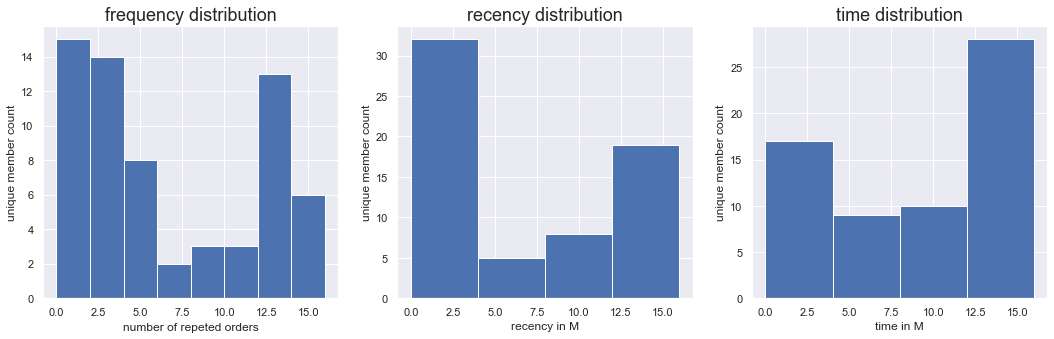

In [109]:
fig, axs = plt.subplots(1, 3,
                        figsize=(18, 5))

# frequency distribution
data['frequency'].plot(kind='hist', 
                       bins=range(0, int(max(data['frequency']))+4, 2),
                       ax=axs[0],
                       title='frequency distribution'
                       )
axs[0].set(xlabel='number of repeted orders', ylabel='unique member count')


# recency distribution

# recency represents the duration between a customer’s first purchase and their latest purchase. 
# (Thus if they have made only 1 purchase, the recency is 0.)

data['recency'].plot(kind='hist', 
                     bins=range(0, int(max(data['recency'])+4), 4),
                     ax=axs[1],
                     title='recency distribution'
                     )
axs[1].set(xlabel=f'recency in {FREQ}', ylabel='unique member count')


# time (T) distribution

# T represents the age of the customer in whatever time units chosen (weekly, in the above dataset). 
# This is equal to the duration between a customer’s first purchase and the end of the period under study.

# recency zeigt wie lange die members bei scoop bleiben

data['T'].plot(kind='hist', 
               bins=range(0, int(max(data['T'])+4), 4),
               ax=axs[2],
               title='time distribution'
               )
axs[2].set(xlabel=f'time in {FREQ}', ylabel='unique member count')

# setting title sizes for all axs 
for ax in axs:
    ax.title.set_size(18)

#plt.tight_layout()

In [110]:
print(data.describe())
print(sum(data['frequency'] == 0) / float(len(data)))

       frequency    recency          T  monetary_value  predicted_purchases
count  64.000000  64.000000  64.000000       64.000000            55.000000
mean    6.218750   6.793774   9.513542      105.845114            20.642286
std     5.286907   5.813617   5.361461       86.344273             8.078150
min     0.000000   0.000000   0.000000        0.000000             1.457420
25%     2.000000   1.987720   3.942586       32.665000            15.840615
50%     4.000000   4.451837  11.992033      107.772917            24.673596
75%    12.250000  12.944824  14.981827      140.536077            26.409353
max    14.000000  14.981827  14.981827      391.586429            27.901944
0.140625


In [ ]:
# Insight 1
# No repeated customer when transforming, as count is the same as unique customer ID above
# both recency and frequency are bimodal distribution: https://www.itl.nist.gov/div898/handbook/eda/section3/histogr5.htm
# recency: around 186 and T around 245
# around 10% people are 0 frequency -> drop nach einem einkauf


### 3.2 Explore Customer Intimacy using BG/NBD model

In [101]:
# fitting model
bgf = BetaGeoFitter(penalizer_coef=0.01) # penalty, to avoid overfitting, between 0.001-0.1
bgf.fit(data['frequency'], data['recency'], data['T']) #fit models and make predictions

print(bgf)

<lifetimes.BetaGeoFitter: fitted with 64 subjects, a: 0.03, alpha: 2.81, b: 0.69, r: 2.05>


In [102]:
#bgf.penalizer_coef, 
#bgf.params_, 
bgf.confidence_intervals_, 
#bgf.standard_errors_,
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,2.049972,0.445373,1.177041,2.922903
alpha,2.810904,0.677062,1.483863,4.137945
a,0.034385,0.030383,-0.025166,0.093937
b,0.691885,0.480697,-0.250281,1.634051


#### 3.2.1 Visualize Frequency/Receny Matrix

<AxesSubplot:title={'center':'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

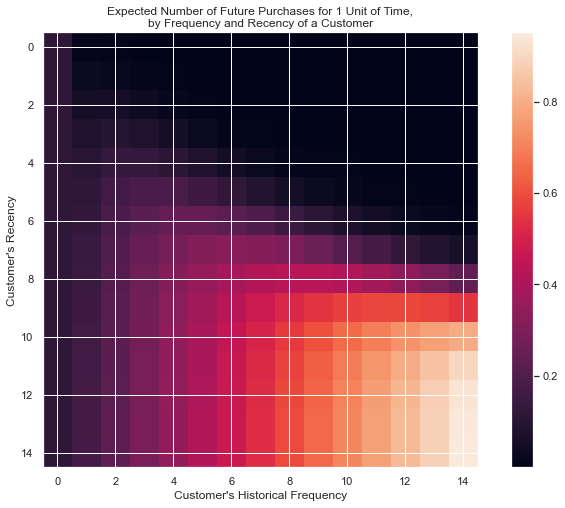

In [103]:
# 1.the probability that the customer will purchase in the future time
fig = plt.figure(figsize=(12,8))
plot_frequency_recency_matrix(bgf) 

# customer with high recency and frequency are most likely to order next month

<AxesSubplot:title={'center':'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

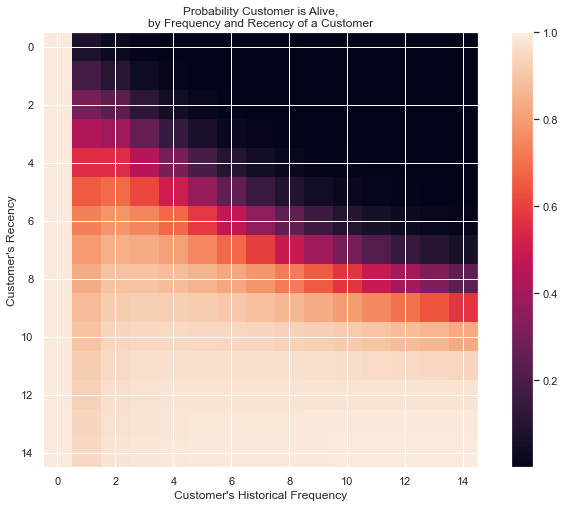

In [104]:
# 2. Probability the customer is alive or not
fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf)

# 

#### 3.2.2 Predict the Probability for Purchasing in a Certain Period of Time

In [105]:
t = 30 # in next 30 days( for some industries that customers not purchase so much)
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], data['recency'], data['T'])
data.sort_values(by='predicted_purchases').tail(5)


,frequency,recency,T,monetary_value,predicted_purchases
member_ID,,,,,
36,0.0,0.0,12.944824,0.0,NaN
40,0.0,0.0,14.981827,0.0,NaN
81,0.0,0.0,0.000000,0.0,NaN
82,0.0,0.0,0.000000,0.0,NaN
83,0.0,0.0,0.000000,0.0,NaN


In [ ]:
# monetary: based on this, the company can decide how much they need to invest
# right frequency, content for advertising/communication with customers

#### 3.2.3 Model Evaluation

In [ ]:
# 1. split dataset as training and testing and make comparison between prediction and testing

<AxesSubplot:title={'center':'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

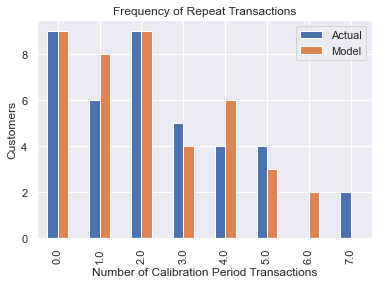

In [106]:
# actual and model comparison
from lifetimes.plotting import plot_period_transactions 
plot_period_transactions(bgf)

In [ ]:
# We see the result is close, especially when the transactions is 5 times
# 0 transaction , a lot of people here
# each number of transaction increased, there are around 100 or 200 people decrease

In [ ]:
#2. According to specific time to manually split dataset

In [72]:
# split dataset as training and validation
from lifetimes.utils import calibration_and_holdout_data 

summary_cal_holdout = calibration_and_holdout_data(df, 'member_ID', 'delivery_date',
                                        calibration_period_end='2011-06-08',
                                        observation_period_end='2011-12-9' )   
print(summary_cal_holdout.head())

ValueError: There is no data available. Check the `observation_period_end` and  `calibration_period_end` and confirm that values in `transactions` occur prior to those dates.

In [ ]:
# 3. Using RMSE

In [73]:
import numpy as np
from matplotlib import *

rmse_train_count = (summary_cal_holdout['frequency_holdout'] - summary_cal_holdout['frequency_cal']).apply(lambda x : x*x)
rmse_train_count = np.sqrt(rmse_train_count.sum()/len(data))
print('RMSE =', rmse_train_count)

NameError: name 'summary_cal_holdout' is not defined

#### 3.2.4 Predict Customer Alive Probability

In [ ]:
from lifetimes.plotting import plot_history_alive

#id = 13093 # long time, low frequency, slowly decreased
id=14096 # short time, high frequency, quickly decreased
# id= 15061 # every interval, start to purchase, high p not decrease
#choose customer id
days_since_birth = 500
sp_trans = df.loc[df['CustomerID'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'InvoiceDate')
#y-axis: the p that the customers are still alive

### 3.3 Predict Customer Purchase Power using GAMMA-GAMMA

In [ ]:
returning_customers_summary = data[data['frequency'] > 0] # filter those only have 1 purchase
print(returning_customers_summary.head())

print(len(returning_customers_summary))

In [ ]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0)#avoid overfitting by adusting penalty, default value is zero
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])

print(ggf)

In [ ]:
data.sort_values(by='predicted_purchases').tail(5)

In [ ]:
# calculate the average profit for customer
gg = ggf.conditional_expected_average_profit(
        data['frequency'],
        data['monetary_value']
        ).sort_values()

print(gg)

In [ ]:
# Make prediction for customers's purchase frequency in next T based on BGF, EG

In [ ]:
t = 90
individual = data.loc[12347]
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

In [ ]:
print(416.94 * 1.4054323465114449)

In [ ]:
ggdf = pd.DataFrame({'CustomerID':gg.index, 
                     'average_profit':gg.values})

In [ ]:
ggdf.sort_values(by=['CustomerID'])

In [ ]:
data.head()

In [ ]:
result = pd.merge(ggdf,
                 data,
                 on='CustomerID')
result.head()

In [ ]:
#generate customer_lifetime_value in next T( 90 days)
result["cust_value_ninety"]=result["average_profit"]*result["predicted_purchases"]

In [ ]:
result["cust_value_ninety"].sum()

In [ ]:
result.head()